<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Get-scraped-articles-from-database" data-toc-modified-id="Get-scraped-articles-from-database-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Get scraped articles from database</a></span></li><li><span><a href="#Clean-articles" data-toc-modified-id="Clean-articles-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Clean articles</a></span></li><li><span><a href="#Analyse-the-articles" data-toc-modified-id="Analyse-the-articles-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Analyse the articles</a></span></li><li><span><a href="#Extract-the-urls-for-continuing-of-scraping" data-toc-modified-id="Extract-the-urls-for-continuing-of-scraping-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Extract the urls for continuing of scraping</a></span></li></ul></div>

In [1]:
%matplotlib inline
%load_ext dotenv
%dotenv -o

import os
import random
import multiprocessing
from datetime import datetime
from urllib.parse import urlsplit

import ujson
import psycopg2
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib as mpl
from peewee import Model
from newspaper import Article
import matplotlib.pyplot as plt
from newspaper.article import ArticleDownloadState
from playhouse.shortcuts import model_to_dict
from playhouse.postgres_ext import PostgresqlExtDatabase, DateTimeField, CharField, TextField, IntegerField, fn

In [2]:
## this stuff should be moved somewhere :) 

peewee_database = PostgresqlExtDatabase(os.environ['RESEARCHABLY_DB_NAME'], **{
    'host': os.environ    ['RESEARCHABLY_DB_HOST'],
    'user': os.environ    ['RESEARCHABLY_DB_USER'],
    'password': os.environ['RESEARCHABLY_DB_PASSWORD'],
    'register_hstore':    False
})


class BaseModel(Model):
    class Meta:
        database = peewee_database

        
class ScrapedPage(BaseModel):
    batch = IntegerField(null=False)
    url = CharField(null=False)
    html = TextField(null=False)
    inserted_at = DateTimeField(null=False, default=datetime.now())
    updated_at = DateTimeField(null=False, default=datetime.now())

    class Meta:
        db_table = 'fnr_scraped_pages'
        
        
def big_select_query(query, batch_size=2000):
    cursor = peewee_database._local.conn.cursor(cursor_factory=psycopg2.extras.RealDictCursor)
    cursor_name = 'task_big_query' + str(random.randint(1, 1000 * 1000))
    cursor.execute('begin; declare ' + cursor_name + ' cursor for ' + query.sql()[0], query.sql()[1])

    while True:
        cursor.execute('fetch ' + str(batch_size) + ' from ' + cursor_name + ' ;')
        batch_results = cursor.fetchall()

        if len(batch_results) <= 0:
            break

        for row in batch_results:
            yield row

    cursor.close()

# Get scraped articles from database

In [3]:
scraped_pages_count = list(ScrapedPage.select(fn.Count(ScrapedPage.id).alias('count')).where((ScrapedPage.batch == 2) |
                                                                                             (ScrapedPage.batch == 3) |
                                                                                             (ScrapedPage.batch == 4)))
scraped_pages_count = scraped_pages_count[0].count
scraped_pages_count

6242249

In [ ]:
peewee_database.connect()

In [5]:
with open('data/7_opensources_co/scraped_urls.jsonl', 'w') as _out:
    for page in tqdm(big_select_query(ScrapedPage.select(ScrapedPage.id, ScrapedPage.batch, ScrapedPage.url) \
                                      .where((ScrapedPage.batch == 2) | (ScrapedPage.batch == 3) | 
                                             (ScrapedPage.batch == 4)), 10000)):
        _out.write(ujson.dumps(page) + '\n')


0it [00:00, ?it/s]
1it [00:00,  3.48it/s]
10001it [00:00,  4.97it/s]
20001it [00:00,  7.10it/s]
30001it [00:00, 10.14it/s]
37077it [00:00, 14.48it/s]
42476it [00:01, 20.68it/s]
50001it [00:01, 29.54it/s]
60001it [00:01, 42.19it/s]
68469it [00:01, 60.26it/s]
73992it [00:01, 85.99it/s]
80001it [00:02, 122.67it/s]
90001it [00:02, 175.09it/s]
100001it [00:02, 249.82it/s]
106764it [00:02, 356.32it/s]
112329it [00:02, 506.50it/s]
120001it [00:02, 719.86it/s]
130001it [00:03, 1020.37it/s]
140001it [00:03, 1439.81it/s]
150001it [00:03, 2036.60it/s]
160001it [00:03, 2869.58it/s]
170001it [00:03, 4022.71it/s]
180001it [00:04, 5575.94it/s]
190001it [00:04, 7696.96it/s]
200001it [00:04, 10405.78it/s]
210001it [00:04, 13783.45it/s]
220001it [00:04, 17991.59it/s]
230001it [00:05, 21165.27it/s]
240001it [00:05, 25183.42it/s]
250001it [00:05, 29717.53it/s]
260001it [00:05, 34604.61it/s]
270001it [00:05, 39466.32it/s]
280001it [00:06, 39188.92it/s]
290001it [00:06, 42335.28it/s]
300001it [00:06, 45739

In [ ]:
1

# Clean articles

In [4]:
def parse_article(line):
    try:
        page = ujson.loads(line)
        article = Article(page['url'])
        article.set_html(page['html'])
        article.config.fetch_images = False
        article.parse()

        return ujson.dumps({
            'id': page['id'],
            'batch': page['batch'],
            'url': page['url'],
            'title': article.title,
            'content': article.text,
            'published_at': article.publish_date,
            'authors': article.authors,
            'meta_description': article.meta_description,
            'meta_keywords': article.meta_keywords
        })
    except Exception as a:
        print(a)
        return None

In [5]:
def yield_scraped_pages():
    with open('data/7_opensources_co/scraped_pages.jsonl', 'r') as _in:
        for line in _in:
            yield line

with multiprocessing.Pool(multiprocessing.cpu_count()) as pool:
    with open('data/7_opensources_co/scraped_pages_articles.jsonl', 'w') as _out:
        for result in tqdm(pool.imap(parse_article, yield_scraped_pages(), chunksize=100)):
            if result is None:
                continue

            _out.write(result + '\n')


0it [00:00, ?it/s]
1it [00:11, 11.83s/it]
101it [00:13,  7.50it/s]
101it [00:26,  3.86it/s]
201it [01:05,  3.05it/s]
5501it [01:06, 82.26it/s]
5672it [01:08, 83.29it/s]
5796it [01:11, 81.53it/s]
5884it [01:11, 81.97it/s]
5950it [01:12, 82.57it/s]
6003it [01:12, 82.45it/s]
6301it [01:13, 85.70it/s]
6401it [01:14, 86.14it/s]
6701it [01:14, 89.43it/s]
6801it [01:17, 88.07it/s]
6901it [01:17, 88.91it/s]
7001it [01:19, 87.71it/s]
7201it [01:21, 88.32it/s]
7301it [01:24, 86.78it/s]
7501it [01:24, 88.44it/s]
7701it [01:27, 88.11it/s]
8001it [01:28, 90.69it/s]
8301it [01:29, 92.48it/s]
8401it [01:31, 91.73it/s]
8501it [01:32, 92.14it/s]
8601it [01:33, 92.12it/s]
8801it [01:35, 92.25it/s]
8901it [01:37, 90.85it/s]
9001it [01:38, 91.13it/s]
9201it [01:39, 92.67it/s]
9301it [01:41, 91.22it/s]
9401it [01:42, 91.90it/s]
9601it [01:42, 93.71it/s]
9901it [01:44, 94.92it/s]
10001it [01:46, 94.30it/s]
10201it [01:47, 94.78it/s]
10301it [01:48, 95.12it/s]
10401it [01:49, 95.28it/s]
10501it [01:52, 93.4

You must `download()` an article first!

You must `download()` an article first!




201701it [26:36, 126.38it/s]
202201it [26:37, 126.56it/s]
202601it [26:38, 126.71it/s]
202701it [26:45, 126.23it/s]
202701it [26:57, 125.32it/s]
203101it [26:58, 125.49it/s]
203201it [27:00, 125.43it/s]
203601it [27:00, 125.61it/s]
203701it [27:02, 125.56it/s]
204201it [27:05, 125.61it/s]
204601it [27:10, 125.46it/s]
205601it [27:13, 125.89it/s]
205701it [27:22, 125.27it/s]
206601it [27:28, 125.35it/s]
207101it [27:41, 124.67it/s]
208901it [27:41, 125.72it/s]
209201it [27:41, 125.89it/s]
209401it [27:44, 125.78it/s]
209515it [27:46, 125.75it/s]
209601it [27:46, 125.74it/s]
209701it [27:52, 125.38it/s]
210401it [27:53, 125.71it/s]
210701it [27:54, 125.86it/s]
211101it [27:55, 126.03it/s]
211201it [27:55, 126.07it/s]
211301it [27:58, 125.90it/s]
211601it [28:00, 125.92it/s]
211701it [28:02, 125.81it/s]
212301it [28:04, 126.01it/s]
212501it [28:05, 126.08it/s]
212601it [28:06, 126.06it/s]
212701it [28:07, 126.07it/s]
212801it [28:07, 126.11it/s]
212901it [28:09, 126.02it/s]
213001it [28:

You must `download()` an article first!

You must `download()` an article first!

You must `download()` an article first!

You must `download()` an article first!

You must `download()` an article first!

You must `download()` an article first!

You must `download()` an article first!




303901it [39:42, 127.55it/s]
304001it [39:45, 127.43it/s]
304301it [39:46, 127.49it/s]

You must `download()` an article first!

You must `download()` an article first!

You must `download()` an article first!




304401it [39:53, 127.18it/s]

You must `download()` an article first!

You must `download()` an article first!

You must `download()` an article first!

You must `download()` an article first!




304401it [40:08, 126.41it/s]

You must `download()` an article first!

You must `download()` an article first!

You must `download()` an article first!

You must `download()` an article first!

You must `download()` an article first!

You must `download()` an article first!

You must `download()` an article first!

You must `download()` an article first!

You must `download()` an article first!

You must `download()` an article first!

You must `download()` an article first!

You must `download()` an article first!

You must `download()` an article first!

You must `download()` an article first!

You must `download()` an article first!

You must `download()` an article first!

You must `download()` an article first!

You must `download()` an article first!

You must `download()` an article first!

You must `download()` an article first!




304501it [40:39, 124.80it/s]

You must `download()` an article first!

You must `download()` an article first!

You must `download()` an article first!

You must `download()` an article first!

You must `download()` an article first!

You must `download()` an article first!

You must `download()` an article first!

You must `download()` an article first!

You must `download()` an article first!

You must `download()` an article first!

You must `download()` an article first!




305301it [41:13, 123.43it/s]

You must `download()` an article first!

You must `download()` an article first!

You must `download()` an article first!

You must `download()` an article first!




305301it [41:28, 122.70it/s]

You must `download()` an article first!

You must `download()` an article first!

You must `download()` an article first!

You must `download()` an article first!

You must `download()` an article first!

You must `download()` an article first!

You must `download()` an article first!




305401it [41:39, 122.17it/s]

You must `download()` an article first!




305501it [42:22, 120.16it/s]
313736it [42:22, 123.39it/s]
316027it [42:23, 124.27it/s]
316027it [42:38, 123.53it/s]
317401it [42:38, 124.04it/s]
317501it [42:44, 123.82it/s]
318401it [42:45, 124.12it/s]
318701it [42:47, 124.14it/s]
318801it [42:50, 124.00it/s]
319001it [42:54, 123.89it/s]
319701it [42:54, 124.16it/s]
319862it [42:55, 124.21it/s]
320201it [42:56, 124.30it/s]
320309it [42:58, 124.24it/s]
320401it [43:00, 124.18it/s]
320501it [43:01, 124.14it/s]
320601it [43:02, 124.13it/s]
320701it [43:03, 124.14it/s]
320801it [43:04, 124.14it/s]
320901it [43:04, 124.15it/s]
321101it [43:05, 124.20it/s]
321501it [43:05, 124.35it/s]
321601it [43:06, 124.36it/s]
321801it [43:06, 124.43it/s]
321901it [43:08, 124.38it/s]
322001it [43:10, 124.31it/s]
322101it [43:11, 124.29it/s]
322201it [43:13, 124.26it/s]
322301it [43:13, 124.27it/s]
322401it [43:14, 124.27it/s]
322501it [43:14, 124.29it/s]
322601it [43:15, 124.31it/s]
322901it [43:15, 124.40it/s]
323001it [43:15, 124.43it/s]
323301it [43:

You must `download()` an article first!




419001it [57:46, 120.89it/s]
419501it [57:46, 121.02it/s]
419601it [57:54, 120.77it/s]
420601it [57:55, 121.03it/s]
420901it [57:55, 121.09it/s]

You must `download()` an article first!




421001it [58:06, 120.75it/s]
422101it [58:06, 121.06it/s]
422325it [58:10, 121.00it/s]
422484it [58:12, 120.98it/s]
422598it [58:14, 120.94it/s]
423401it [58:14, 121.17it/s]
423657it [58:14, 121.23it/s]
423858it [58:18, 121.14it/s]
424001it [58:20, 121.14it/s]
424104it [58:21, 121.12it/s]
424201it [58:29, 120.88it/s]
424701it [58:32, 120.92it/s]
425801it [58:32, 121.22it/s]
425920it [58:34, 121.19it/s]
426005it [58:36, 121.15it/s]
426101it [58:37, 121.13it/s]
426301it [58:38, 121.17it/s]
426401it [58:39, 121.17it/s]
426501it [58:40, 121.16it/s]
426601it [58:43, 121.08it/s]
426801it [58:45, 121.06it/s]
427301it [58:47, 121.15it/s]
427601it [58:50, 121.13it/s]
427701it [58:50, 121.14it/s]
427801it [58:51, 121.15it/s]
427901it [58:52, 121.13it/s]
428101it [58:54, 121.12it/s]
428201it [58:58, 121.02it/s]

You must `download()` an article first!

You must `download()` an article first!

You must `download()` an article first!




428701it [59:04, 120.93it/s]
429201it [59:07, 120.97it/s]
429801it [59:10, 121.05it/s]
430101it [59:11, 121.11it/s]
430301it [59:14, 121.06it/s]
430601it [59:15, 121.11it/s]
430701it [59:18, 121.03it/s]
430801it [59:21, 120.97it/s]
431201it [59:21, 121.08it/s]
431401it [59:21, 121.14it/s]
431528it [59:22, 121.15it/s]
431623it [59:24, 121.09it/s]
431701it [59:28, 120.99it/s]
432101it [59:28, 121.08it/s]
432201it [59:33, 120.94it/s]
432601it [59:33, 121.04it/s]
432701it [59:35, 121.03it/s]
433101it [59:35, 121.12it/s]
433201it [59:40, 121.00it/s]
433601it [59:41, 121.08it/s]
433701it [59:41, 121.10it/s]
433801it [59:43, 121.07it/s]
433901it [59:43, 121.07it/s]
434001it [59:44, 121.06it/s]
434101it [59:46, 121.03it/s]
434401it [59:47, 121.10it/s]
434501it [59:47, 121.10it/s]
434601it [59:49, 121.08it/s]
434801it [59:50, 121.09it/s]
434901it [59:52, 121.06it/s]
435001it [59:53, 121.05it/s]
435101it [59:54, 121.06it/s]
435401it [1:00:04, 120.80it/s]
435901it [1:00:04, 120.93it/s]
436501it 

You must `download()` an article first!

You must `download()` an article first!




439601it [1:00:31, 121.05it/s]
439901it [1:00:33, 121.05it/s]
440001it [1:00:35, 121.02it/s]
440101it [1:00:36, 121.02it/s]
440201it [1:00:37, 121.02it/s]
440301it [1:00:37, 121.05it/s]
440401it [1:00:37, 121.06it/s]
440501it [1:00:38, 121.07it/s]
440701it [1:00:40, 121.06it/s]
440801it [1:00:41, 121.05it/s]
440901it [1:00:43, 121.00it/s]
441301it [1:00:44, 121.08it/s]
441401it [1:00:44, 121.11it/s]
441501it [1:00:47, 121.03it/s]
441701it [1:00:48, 121.07it/s]
441801it [1:00:50, 121.02it/s]

You must `download()` an article first!




441901it [1:00:57, 120.82it/s]
443001it [1:00:58, 121.07it/s]
443101it [1:00:59, 121.07it/s]
443201it [1:01:01, 121.03it/s]
443501it [1:01:06, 120.96it/s]
443901it [1:01:07, 121.04it/s]
444001it [1:01:08, 121.02it/s]
444201it [1:01:09, 121.05it/s]
444401it [1:01:10, 121.07it/s]
444501it [1:01:11, 121.05it/s]
444601it [1:01:13, 121.03it/s]
444701it [1:01:16, 120.95it/s]
444901it [1:01:17, 120.98it/s]
445001it [1:01:22, 120.85it/s]
446001it [1:01:22, 121.10it/s]
446101it [1:01:26, 121.02it/s]
446301it [1:01:28, 121.01it/s]
446401it [1:01:29, 120.98it/s]
446701it [1:01:34, 120.93it/s]
447201it [1:01:34, 121.05it/s]
447301it [1:01:34, 121.07it/s]
447501it [1:01:36, 121.05it/s]
447701it [1:01:37, 121.08it/s]
447801it [1:01:38, 121.09it/s]
447901it [1:01:41, 121.01it/s]
448001it [1:01:42, 121.01it/s]
448201it [1:01:42, 121.04it/s]
448301it [1:01:43, 121.04it/s]
448401it [1:01:43, 121.06it/s]
448501it [1:01:51, 120.84it/s]
448901it [1:01:57, 120.76it/s]
450101it [1:01:57, 121.06it/s]
450201i

You must `download()` an article first!




456701it [1:02:34, 121.63it/s]
457001it [1:02:35, 121.69it/s]
457101it [1:02:35, 121.71it/s]
457301it [1:02:39, 121.65it/s]
457401it [1:02:39, 121.65it/s]
457501it [1:02:40, 121.67it/s]
457601it [1:02:40, 121.68it/s]
457701it [1:02:41, 121.68it/s]
457801it [1:02:43, 121.65it/s]
458201it [1:02:43, 121.75it/s]
458301it [1:02:45, 121.72it/s]
458601it [1:02:52, 121.56it/s]
458701it [1:03:05, 121.18it/s]
458801it [1:03:20, 120.71it/s]
461501it [1:03:24, 121.31it/s]
462201it [1:03:25, 121.45it/s]
462301it [1:03:26, 121.46it/s]
462401it [1:03:27, 121.45it/s]
462501it [1:03:27, 121.46it/s]
462601it [1:03:28, 121.48it/s]
462801it [1:03:30, 121.45it/s]
463001it [1:03:31, 121.46it/s]
463101it [1:03:34, 121.41it/s]
463401it [1:03:34, 121.47it/s]
463501it [1:03:39, 121.35it/s]
463701it [1:03:40, 121.38it/s]
463801it [1:03:43, 121.31it/s]
463901it [1:03:45, 121.26it/s]
464001it [1:03:48, 121.19it/s]
464601it [1:03:52, 121.23it/s]
464901it [1:03:54, 121.24it/s]
465001it [1:03:54, 121.26it/s]
465101i

You must `download()` an article first!




497801it [1:07:05, 123.66it/s]
497901it [1:07:07, 123.64it/s]
498201it [1:07:07, 123.70it/s]
498301it [1:07:08, 123.70it/s]
498401it [1:07:08, 123.71it/s]
498501it [1:07:09, 123.72it/s]
498801it [1:07:09, 123.79it/s]
499001it [1:07:10, 123.80it/s]
499101it [1:07:13, 123.74it/s]
499501it [1:07:14, 123.82it/s]
499601it [1:07:16, 123.78it/s]
499701it [1:07:16, 123.80it/s]
499801it [1:07:17, 123.80it/s]
499901it [1:07:17, 123.81it/s]
500201it [1:07:21, 123.76it/s]
500301it [1:07:22, 123.77it/s]
500401it [1:07:22, 123.79it/s]
500501it [1:07:23, 123.77it/s]
500801it [1:07:27, 123.72it/s]
501201it [1:07:30, 123.75it/s]
501401it [1:07:30, 123.79it/s]
501901it [1:07:32, 123.85it/s]
502001it [1:07:33, 123.84it/s]
502201it [1:07:33, 123.88it/s]
502501it [1:07:34, 123.94it/s]
502601it [1:07:34, 123.96it/s]
502701it [1:07:35, 123.94it/s]
502801it [1:07:36, 123.94it/s]
502901it [1:07:37, 123.93it/s]
503001it [1:07:40, 123.88it/s]
503201it [1:07:41, 123.89it/s]
503301it [1:07:43, 123.85it/s]
503501i

You must `download()` an article first!




613001it [1:22:46, 123.42it/s]
613201it [1:22:49, 123.40it/s]
613601it [1:22:49, 123.46it/s]
613701it [1:22:50, 123.48it/s]
613901it [1:22:50, 123.51it/s]
614001it [1:22:50, 123.53it/s]
614401it [1:22:50, 123.60it/s]
614601it [1:22:54, 123.54it/s]
615101it [1:22:56, 123.61it/s]
615601it [1:22:59, 123.62it/s]
615901it [1:23:00, 123.66it/s]
616801it [1:23:00, 123.84it/s]
616945it [1:23:04, 123.76it/s]
617301it [1:23:05, 123.82it/s]
617801it [1:23:08, 123.85it/s]
617901it [1:23:12, 123.78it/s]
618201it [1:23:12, 123.83it/s]
618701it [1:23:15, 123.85it/s]
619201it [1:23:16, 123.94it/s]
619301it [1:23:16, 123.95it/s]
619401it [1:23:19, 123.89it/s]
619501it [1:23:20, 123.88it/s]
619601it [1:23:22, 123.85it/s]
619701it [1:23:23, 123.86it/s]
619901it [1:23:23, 123.89it/s]
620001it [1:23:26, 123.85it/s]
620201it [1:23:27, 123.87it/s]
620301it [1:23:29, 123.83it/s]
620401it [1:23:29, 123.84it/s]
620601it [1:23:30, 123.85it/s]
620701it [1:23:31, 123.87it/s]
620801it [1:23:31, 123.88it/s]
621001i

You must `download()` an article first!




777901it [1:41:05, 128.25it/s]

You must `download()` an article first!




778001it [1:41:06, 128.24it/s]
778101it [1:41:09, 128.21it/s]
778201it [1:41:10, 128.20it/s]
778601it [1:41:10, 128.26it/s]
778901it [1:41:12, 128.27it/s]
779501it [1:41:15, 128.29it/s]
779701it [1:41:17, 128.29it/s]
779901it [1:41:19, 128.28it/s]
780101it [1:41:20, 128.29it/s]
780601it [1:41:21, 128.35it/s]
781101it [1:41:23, 128.39it/s]
781201it [1:41:25, 128.37it/s]
781301it [1:41:28, 128.33it/s]
781401it [1:41:28, 128.34it/s]
781601it [1:41:28, 128.36it/s]
781701it [1:41:29, 128.37it/s]
781801it [1:41:29, 128.38it/s]
782001it [1:41:30, 128.41it/s]
782201it [1:41:31, 128.40it/s]
782301it [1:41:33, 128.39it/s]
782401it [1:41:33, 128.40it/s]
782701it [1:41:34, 128.43it/s]
782801it [1:41:35, 128.41it/s]
782901it [1:41:38, 128.38it/s]
783001it [1:41:41, 128.34it/s]
783801it [1:41:42, 128.44it/s]
783901it [1:41:44, 128.41it/s]
784401it [1:41:45, 128.47it/s]
784501it [1:41:48, 128.42it/s]
785001it [1:41:49, 128.49it/s]
785101it [1:41:49, 128.49it/s]
785201it [1:41:50, 128.49it/s]
785401i

You must `download()` an article first!




802501it [1:43:56, 128.68it/s]
802601it [1:44:05, 128.51it/s]
804001it [1:44:06, 128.70it/s]
804101it [1:44:11, 128.63it/s]
804201it [1:44:13, 128.60it/s]
804501it [1:44:13, 128.64it/s]
804701it [1:44:15, 128.64it/s]
804801it [1:44:15, 128.65it/s]
804901it [1:44:15, 128.66it/s]
805001it [1:44:16, 128.67it/s]
805101it [1:44:16, 128.67it/s]
805301it [1:44:17, 128.70it/s]
805401it [1:44:18, 128.70it/s]
805601it [1:44:18, 128.72it/s]
805701it [1:44:24, 128.61it/s]
805801it [1:44:25, 128.61it/s]
805901it [1:44:34, 128.43it/s]
806401it [1:44:40, 128.40it/s]
806401it [1:44:51, 128.18it/s]
806501it [1:44:51, 128.18it/s]
806601it [1:45:15, 127.73it/s]
806701it [1:45:19, 127.66it/s]
806701it [1:45:31, 127.41it/s]
807001it [1:45:40, 127.28it/s]
807301it [1:45:45, 127.22it/s]
807801it [1:45:54, 127.12it/s]
807801it [1:46:11, 126.79it/s]
808301it [1:46:17, 126.73it/s]
811801it [1:46:18, 127.26it/s]
811911it [1:46:20, 127.26it/s]
812101it [1:46:20, 127.27it/s]
812301it [1:46:21, 127.30it/s]
812401i

You must `download()` an article first!




887301it [1:55:38, 127.89it/s]
887801it [1:55:42, 127.89it/s]
888001it [1:55:43, 127.89it/s]
888101it [1:55:44, 127.88it/s]
888601it [1:55:45, 127.93it/s]
888701it [1:55:48, 127.90it/s]
888801it [1:55:49, 127.90it/s]
888901it [1:55:53, 127.84it/s]
889401it [1:55:56, 127.85it/s]
889601it [1:55:57, 127.86it/s]
889701it [1:55:57, 127.87it/s]
890001it [1:55:58, 127.89it/s]
890301it [1:56:00, 127.91it/s]
890401it [1:56:02, 127.88it/s]
890501it [1:56:06, 127.83it/s]
890801it [1:56:06, 127.87it/s]
891001it [1:56:08, 127.87it/s]
891101it [1:56:08, 127.87it/s]
891201it [1:56:09, 127.86it/s]
891301it [1:56:11, 127.84it/s]
891501it [1:56:13, 127.84it/s]

You must `download()` an article first!




891701it [1:56:15, 127.83it/s]
892001it [1:56:16, 127.86it/s]
892101it [1:56:18, 127.83it/s]
892201it [1:56:22, 127.77it/s]
892301it [1:56:24, 127.75it/s]
893301it [1:56:25, 127.88it/s]
893401it [1:56:26, 127.87it/s]
893501it [1:56:28, 127.86it/s]
893601it [1:56:28, 127.86it/s]
893701it [1:56:30, 127.85it/s]
893801it [1:56:32, 127.83it/s]
894001it [1:56:35, 127.80it/s]
894701it [1:56:36, 127.88it/s]
894801it [1:56:38, 127.86it/s]
895001it [1:56:38, 127.88it/s]
895101it [1:56:40, 127.86it/s]
895301it [1:56:41, 127.87it/s]
895401it [1:56:43, 127.84it/s]
895501it [1:56:45, 127.82it/s]
895701it [1:56:46, 127.84it/s]
895901it [1:56:47, 127.85it/s]
896301it [1:56:48, 127.90it/s]
896401it [1:56:49, 127.88it/s]
896501it [1:56:50, 127.87it/s]
896701it [1:56:51, 127.88it/s]
896801it [1:56:53, 127.87it/s]
896901it [1:56:56, 127.83it/s]
897101it [1:56:58, 127.82it/s]
897701it [1:56:58, 127.90it/s]
897801it [1:57:00, 127.88it/s]
898001it [1:57:01, 127.90it/s]
898101it [1:57:03, 127.87it/s]
898201i

You must `download()` an article first!




1029101it [2:14:46, 127.25it/s]
1029201it [2:14:48, 127.25it/s]
1029501it [2:14:50, 127.25it/s]
1029601it [2:14:50, 127.26it/s]
1029701it [2:14:51, 127.26it/s]
1029801it [2:14:52, 127.26it/s]
1029901it [2:14:53, 127.26it/s]
1030201it [2:14:56, 127.24it/s]
1030301it [2:14:56, 127.25it/s]
1030401it [2:14:57, 127.26it/s]
1030501it [2:14:58, 127.24it/s]
1030601it [2:15:02, 127.19it/s]
1030701it [2:15:07, 127.14it/s]
1030901it [2:15:08, 127.14it/s]
1031101it [2:15:08, 127.16it/s]
1031201it [2:15:10, 127.15it/s]
1031501it [2:15:11, 127.16it/s]
1031601it [2:15:12, 127.16it/s]
1031801it [2:15:13, 127.17it/s]
1032001it [2:15:14, 127.19it/s]
1032101it [2:15:19, 127.11it/s]
1032301it [2:15:23, 127.07it/s]
1032501it [2:15:25, 127.07it/s]
1032601it [2:15:29, 127.01it/s]
1033301it [2:15:30, 127.09it/s]
1033401it [2:15:30, 127.10it/s]
1033501it [2:15:32, 127.09it/s]
1033601it [2:15:32, 127.09it/s]
1033701it [2:15:41, 126.97it/s]
1033901it [2:15:49, 126.86it/s]
1034001it [2:15:52, 126.84it/s]
1035601

You must `download()` an article first!




1080501it [2:20:20, 128.31it/s]
1080801it [2:20:22, 128.33it/s]
1080901it [2:20:24, 128.30it/s]
1081201it [2:20:25, 128.33it/s]
1081601it [2:20:26, 128.35it/s]
1081901it [2:20:28, 128.36it/s]
1082001it [2:20:29, 128.35it/s]
1082101it [2:20:34, 128.29it/s]
1082301it [2:20:35, 128.30it/s]
1082501it [2:20:35, 128.32it/s]
1082601it [2:20:37, 128.31it/s]
1082701it [2:20:39, 128.29it/s]
1083001it [2:20:39, 128.32it/s]
1083201it [2:20:40, 128.34it/s]
1083301it [2:20:42, 128.32it/s]
1083601it [2:20:43, 128.34it/s]
1083701it [2:20:47, 128.29it/s]
1083801it [2:20:47, 128.29it/s]
1083901it [2:20:48, 128.29it/s]
1084201it [2:20:49, 128.32it/s]
1084301it [2:20:51, 128.29it/s]
1085001it [2:20:52, 128.37it/s]
1085108it [2:20:52, 128.38it/s]
1085201it [2:20:53, 128.37it/s]
1085301it [2:20:56, 128.33it/s]
1085401it [2:20:58, 128.32it/s]
1085801it [2:20:59, 128.36it/s]
1085901it [2:20:59, 128.37it/s]
1086001it [2:21:00, 128.36it/s]
1086201it [2:21:00, 128.38it/s]
1086301it [2:21:01, 128.38it/s]
1086501

You must `download()` an article first!




1090701it [2:21:37, 128.35it/s]
1091601it [2:21:38, 128.44it/s]
1091701it [2:21:41, 128.41it/s]
1092001it [2:21:42, 128.43it/s]
1092101it [2:21:43, 128.43it/s]
1092201it [2:21:47, 128.38it/s]
1092301it [2:21:48, 128.38it/s]
1092501it [2:21:53, 128.33it/s]
1092801it [2:21:54, 128.35it/s]
1093301it [2:21:57, 128.36it/s]
1093401it [2:21:58, 128.36it/s]
1093701it [2:21:59, 128.37it/s]
1094401it [2:22:00, 128.44it/s]
1094501it [2:22:02, 128.43it/s]
1094601it [2:22:02, 128.44it/s]
1094801it [2:22:03, 128.45it/s]
1094901it [2:22:06, 128.41it/s]
1095101it [2:22:06, 128.43it/s]
1095201it [2:22:07, 128.43it/s]
1095501it [2:22:08, 128.45it/s]
1095601it [2:22:11, 128.42it/s]
1095701it [2:22:11, 128.42it/s]
1095901it [2:22:12, 128.44it/s]
1096001it [2:22:13, 128.44it/s]
1096101it [2:22:16, 128.41it/s]
1096301it [2:22:17, 128.41it/s]
1096401it [2:22:18, 128.40it/s]
1096501it [2:22:20, 128.38it/s]
1096601it [2:22:21, 128.38it/s]
1097001it [2:22:24, 128.39it/s]
1097101it [2:22:28, 128.33it/s]
1097201

You must `download()` an article first!

You must `download()` an article first!



1163201it [2:31:13, 128.20it/s]


You must `download()` an article first!

You must `download()` an article first!

You must `download()` an article first!

You must `download()` an article first!

You must `download()` an article first!

You must `download()` an article first!




1163401it [2:31:13, 128.22it/s]
1163701it [2:31:14, 128.23it/s]
1163901it [2:31:15, 128.25it/s]
1164001it [2:31:16, 128.25it/s]
1164401it [2:31:18, 128.26it/s]
1164501it [2:31:21, 128.23it/s]
1164601it [2:31:24, 128.20it/s]
1164701it [2:31:25, 128.19it/s]
1164801it [2:31:26, 128.19it/s]
1164901it [2:31:26, 128.20it/s]
1165001it [2:31:27, 128.21it/s]
1165101it [2:31:27, 128.21it/s]
1165301it [2:31:29, 128.20it/s]
1166001it [2:31:31, 128.25it/s]
1166101it [2:31:35, 128.20it/s]
1166201it [2:31:39, 128.16it/s]
1166401it [2:31:41, 128.15it/s]
1167301it [2:31:43, 128.23it/s]
1167501it [2:31:43, 128.25it/s]
1167601it [2:31:44, 128.24it/s]
1167701it [2:31:49, 128.18it/s]
1167801it [2:31:51, 128.17it/s]
1167901it [2:31:52, 128.16it/s]
1168101it [2:31:54, 128.16it/s]
1168601it [2:31:54, 128.21it/s]
1168701it [2:31:54, 128.22it/s]
1168801it [2:31:55, 128.22it/s]
1168901it [2:31:56, 128.22it/s]
1169001it [2:31:56, 128.23it/s]
1169101it [2:31:56, 128.23it/s]
1169201it [2:31:57, 128.23it/s]
1169301

You must `download()` an article first!




1227601it [2:39:32, 128.24it/s]
1227701it [2:39:33, 128.24it/s]
1227901it [2:39:33, 128.26it/s]
1228001it [2:39:37, 128.22it/s]
1228101it [2:39:40, 128.18it/s]
1228201it [2:39:41, 128.19it/s]
1228401it [2:39:42, 128.19it/s]
1228601it [2:39:43, 128.20it/s]
1228701it [2:39:44, 128.20it/s]
1229101it [2:39:45, 128.23it/s]
1229201it [2:39:45, 128.24it/s]
1229301it [2:39:47, 128.22it/s]
1229601it [2:39:49, 128.23it/s]
1229701it [2:39:54, 128.17it/s]
1229801it [2:39:54, 128.18it/s]
1229901it [2:39:55, 128.18it/s]
1230001it [2:39:56, 128.17it/s]
1230101it [2:39:56, 128.18it/s]
1230301it [2:39:57, 128.19it/s]
1230501it [2:39:57, 128.20it/s]
1230601it [2:39:58, 128.20it/s]
1230701it [2:39:59, 128.21it/s]
1230801it [2:40:00, 128.21it/s]
1230901it [2:40:00, 128.22it/s]
1231001it [2:40:00, 128.22it/s]
1231101it [2:40:01, 128.21it/s]
1231201it [2:40:03, 128.20it/s]
1231301it [2:40:09, 128.14it/s]
1231501it [2:40:09, 128.15it/s]
1231601it [2:40:10, 128.16it/s]
1231701it [2:40:10, 128.16it/s]
1231801

You must `download()` an article first!

You must `download()` an article first!




1256334it [2:44:21, 127.40it/s]
1257501it [2:44:23, 127.49it/s]
1257601it [2:44:24, 127.49it/s]
1258301it [2:44:26, 127.53it/s]
1258401it [2:44:26, 127.54it/s]
1258501it [2:44:28, 127.52it/s]
1258601it [2:44:30, 127.51it/s]
1258701it [2:44:32, 127.50it/s]
1259001it [2:44:32, 127.52it/s]
1259101it [2:44:34, 127.51it/s]
1259401it [2:44:37, 127.51it/s]
1259701it [2:44:37, 127.54it/s]
1259901it [2:44:41, 127.51it/s]
1260401it [2:44:45, 127.50it/s]
1261301it [2:44:45, 127.59it/s]
1261401it [2:44:47, 127.58it/s]
1261501it [2:44:47, 127.59it/s]
1261601it [2:44:48, 127.59it/s]
1261701it [2:44:49, 127.58it/s]
1261801it [2:44:49, 127.58it/s]
1261901it [2:44:51, 127.58it/s]
1262001it [2:44:53, 127.56it/s]
1262201it [2:44:56, 127.55it/s]
1263101it [2:44:56, 127.63it/s]
1263201it [2:44:57, 127.62it/s]
1263301it [2:44:58, 127.62it/s]
1263401it [2:44:59, 127.62it/s]
1263501it [2:45:00, 127.61it/s]
1263701it [2:45:02, 127.62it/s]
1263801it [2:45:03, 127.61it/s]
1263901it [2:45:04, 127.60it/s]
1264401

# Analyse the articles

In [6]:
pages = []
with open('data/7_opensources_co/scraped_urls.jsonl', 'r') as _in:
    for line in tqdm(_in):
        pages.append(ujson.loads(line))

df_pages = pd.DataFrame(pages)
df_pages


0it [00:00, ?it/s]
14489it [00:00, 144888.41it/s]
32706it [00:00, 154365.40it/s]
52875it [00:00, 166053.96it/s]
74513it [00:00, 178508.88it/s]
97664it [00:00, 191672.66it/s]
120461it [00:00, 201286.25it/s]
139461it [00:00, 191983.15it/s]
157960it [00:00, 182201.44it/s]
178101it [00:00, 187345.52it/s]
201753it [00:01, 199807.97it/s]
221800it [00:01, 196253.90it/s]
242909it [00:01, 200475.92it/s]
263021it [00:01, 170057.37it/s]
284158it [00:01, 180649.36it/s]
304449it [00:01, 186795.70it/s]
324262it [00:01, 190056.98it/s]
343696it [00:01, 183129.14it/s]
362363it [00:01, 182043.53it/s]
380817it [00:02, 182360.48it/s]
399228it [00:02, 169060.62it/s]
416450it [00:02, 165033.89it/s]
434893it [00:02, 170358.54it/s]
457419it [00:02, 183796.52it/s]
478701it [00:02, 191635.84it/s]
499822it [00:02, 197081.43it/s]
521498it [00:02, 202513.55it/s]
542012it [00:02, 203194.21it/s]
562892it [00:02, 204784.51it/s]
583503it [00:03, 201352.33it/s]
609013it [00:03, 214937.10it/s]
630835it [00:03, 209462.8

,batch,id,url
0,2.0,459792,https://www.dailykos.com/stories/2012/6/5/1097...
1,2.0,459793,https://www.dailykos.com/stories/2007/5/1/3298...
2,2.0,459794,https://www.dailykos.com/stories/2011/2/2/9408...
3,2.0,459795,https://www.dailykos.com/stories/2011/2/10/942...
4,2.0,459796,https://www.dailykos.com/stories/2011/2/3/9407...
5,2.0,459797,https://www.dailykos.com/stories/2011/2/10/942...
6,2.0,459798,http://www.thedailymash.co.uk/news/society/men...
7,2.0,459799,http://www.thedailymash.co.uk/news/society/mum...
8,2.0,459800,https://www.dailykos.com/stories/2013/6/29/121...
9,2.0,459801,https://www.dailykos.com/stories/2012/9/2/1126...


In [7]:
netlocs_count = {}
with tqdm(total=len(df_pages)) as progress:
    for url in df_pages.url:
        netloc = urlsplit(url).netloc
        if netloc not in netlocs_count:
            netlocs_count[netloc] = 0

        netlocs_count[netloc] += 1
        progress.update()


100%|██████████| 6242249/6242249 [02:19<00:00, 44632.48it/s]

In [8]:
df_netlocs_count = pd.DataFrame([{'domain': k, 'count': v} for k, v in netlocs_count.items()]).sort_values('count', ascending=False)
df_netlocs_count

,count,domain
97,850832,www.dailykos.com
531,664348,beforeitsnews.com
125,473395,www.nationalreview.com
178,408617,www.express.co.uk
441,279381,sputniknews.com
858,204944,www.abovetopsecret.com
626,138807,pjmedia.com
346,109159,www.newsmax.com
594,100981,www.pravda.ru
787,82309,www.lifezette.com


In [9]:
df_netlocs_count.to_excel('data/7_opensources_co/scraped_urls_domain_count.xlsx')

In [16]:
df_netlocs_count = pd.read_excel('data/7_opensources_co/scraped_urls_domain_count.xlsx')

In [17]:
df_netlocs_count = df_netlocs_count.sort_values('count', ascending=False)
df_netlocs_count.columns = ['Number of scraped pages so far', 'Domain']
df_netlocs_count

,Number of scraped pages so far,Domain
97,850832,www.dailykos.com
531,664348,beforeitsnews.com
125,473395,www.nationalreview.com
178,408617,www.express.co.uk
441,279381,sputniknews.com
858,204944,www.abovetopsecret.com
626,138807,pjmedia.com
346,109159,www.newsmax.com
594,100981,www.pravda.ru
787,82309,www.lifezette.com


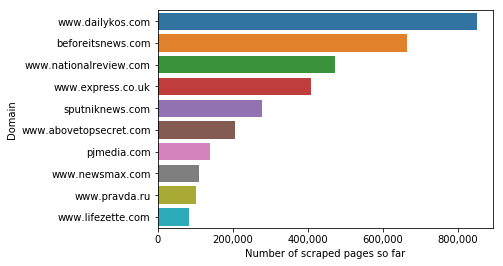

In [19]:
bp = sns.barplot(df_netlocs_count['Number of scraped pages so far'][:10], df_netlocs_count['Domain'][:10])
bp.get_xaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
bp.get_xaxis().set_major_locator(mpl.ticker.MultipleLocator(200 * 1000))
bp.get_xaxis().set_label('Number of scraped pages so far')
bp.get_yaxis().set_label('Number of scraped pages so far')

In [35]:
bp.get_figure().subplots_adjust(left=0.38, right=0.98)
bp.get_figure().savefig('data/7_opensources_co/number_of_scraped_pages_for_10_domains.png', dpi = 300)

In [12]:
len(df_pages.url), len(df_pages.drop_duplicates('url'))

(6242249, 6240157)

In [39]:
df_pages[df_pages.url.str.contains('www.express.co.uk')]

,authors,batch,content,id,meta_description,meta_keywords,published_at,title,url
1550,"[Charlie Bayliss Exclusive, Karin Von Hippel]",2,REUTERS/ GETTY Karin von Hippel warned Europe ...,262071,EUROPE should brace itself for more terror att...,[],1477447320,BRITAIN TERROR WARNING: ISIS jihadis ‘WILL unl...,http://www.express.co.uk/news/world/725238/Mos...
1551,"[Alix Culbertson, Lord Hague]",2,GETTY William Hague has blasted President-elec...,262072,TORY heavyweight William Hague has branded Don...,[],1479882840,William Hague brands Donald Trump ‘a JOKE’ who...,http://www.express.co.uk/news/world/735343/Wil...
1562,[],2,Coronation Street spoilers: Todd Grimshaw exit...,262083,TV and Celebrity news,[],None,TV and Celebrity,http://www.express.co.uk/showbiz
1563,[],2,When is the next meteor shower in the UK? Date...,262084,"Latest UK news, breaking news and current news...",[],None,Breaking News and Opinion,http://www.express.co.uk/news
1571,[],2,BONFIRE NIGHT WEATHER: Check the fireworks nig...,262092,"The weather forecast for London, Manchester, B...",[],None,Weather Forecast for the UK,http://www.express.co.uk/news/weather
1610,"[Nicole Stinson, Theresa May]",2,Her stark warning comes amid fears her “weak” ...,262131,THERESA May has warned Tory rebels and Remoane...,[],1510272480,Brexit WILL happen: May warns Remoaner MPs she...,http://www.express.co.uk/news/uk/877753/Theres...
1611,[Taryn Tarrant-Cornish],2,The demand comes after the Prime Minister fail...,262132,THERESA May’s only chance to redeem herself an...,[],1510302480,Furious Question Time audience attack May 'fai...,http://www.express.co.uk/news/uk/877755/Questi...
1612,[Matt Drake],2,The former Prime Minister is not hopeful about...,262133,GORDON Brown has attacked Britain’s chances of...,[],1510279740,"'We will have NO control of borders, courts or...",http://www.express.co.uk/news/politics/877758/...
1615,"[Rebecca Perring, Lady Pamela Hicks]",2,But from that momentous day in 1947 the monarc...,262136,THE QUEEN will mark her 70th wedding anniversa...,[],1510237560,Queen and Prince Philip's 70th wedding anniver...,http://www.express.co.uk/news/royal/877508/Que...
1616,[Prince Charles],2,GETTY Prince Charles praised the Commonwealth'...,262137,"THE Commonwealth's diversity of people, cultur...",[],1510185600,Charles praises Commonwealth: Diversity can he...,http://www.express.co.uk/news/royal/877514/Pri...


# Extract the urls for continuing of scraping

In [40]:
with open('data/7_opensources_co/scraped_pages_urls.json', 'w') as _out: 
    ujson.dump(list(df_pages.url.values), _out)